# Построение модели для рекомендации подходящих тарифов мобильной связи

## Введение

**Вводные данные проекта:**

*Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».*

*В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.*



**Целью проекта является** построение качественной модели для получения максимального дохода для компании с значением **accuracy** не ниже 0.75. 

**Этапы проекта:**
1. Изучить общую информацию об имеющихся данных
2. Разделить данные на три выборки: обучающую, валидационную и тестовую
3. Исследовать различные модели посредством изменения гиперпараметров, выбрать наиболее качественную модель
4. Проверить качество полученной модели на тестовой выборке
5. Проверить модель на адекватность

**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 

Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Изучение общей информации о данных

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, fbeta_score, classification_report
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
display(df.head())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
# посмотрим общую информацию о данных
temp = df.copy() 
list_c = ['calls', 'minutes', 'messages', 'mb_used', 'is_ultra']
print(temp.info())
for col_l in list_c:
    print('-'* 25)
    print(col_l, temp[col_l].sort_values().unique())
    print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None
-------------------------
calls [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104.

Пропусков в данных нет. Изменим тип данных у переменных call и messages на int.

In [4]:
df['calls'] = df['calls'].astype(int)
df['messages'] = df['messages'].astype(int)
df['is_ultra'] = df['is_ultra'].astype('category')

# проверим типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   calls     3214 non-null   int64   
 1   minutes   3214 non-null   float64 
 2   messages  3214 non-null   int64   
 3   mb_used   3214 non-null   float64 
 4   is_ultra  3214 non-null   category
dtypes: category(1), float64(2), int64(2)
memory usage: 103.8 KB


In [5]:
# проверим на дубликаты
df.duplicated().sum()

0

Дубликаты отсутствуют.

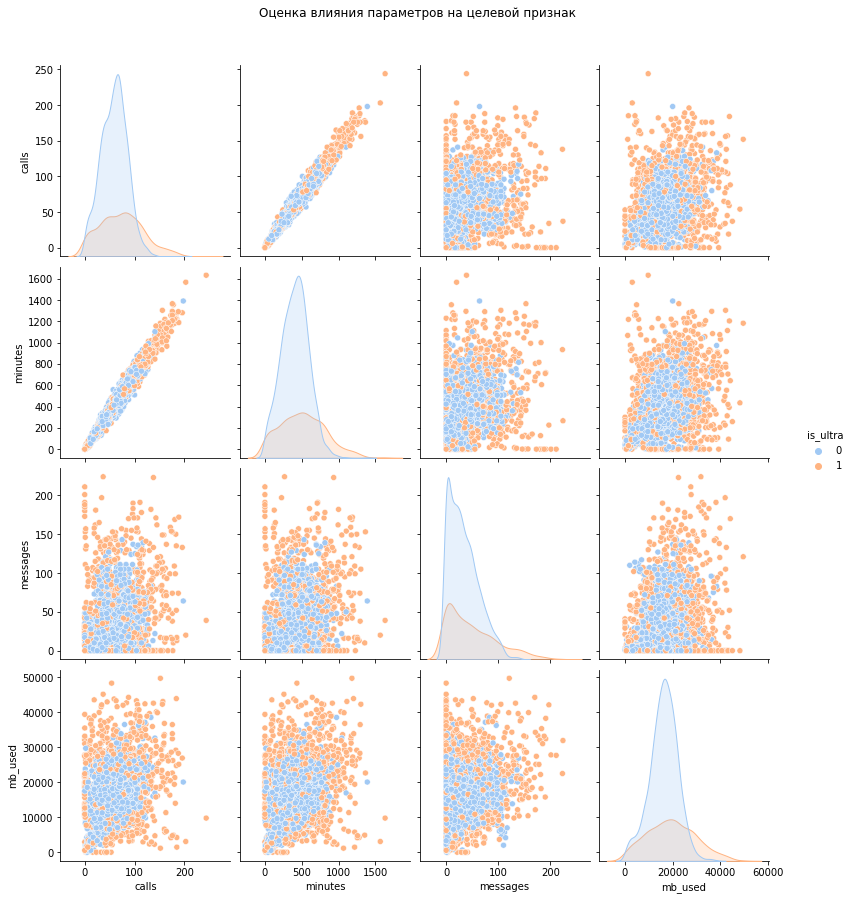

In [76]:
sns.pairplot(df, hue='is_ultra', palette='pastel')
plt.suptitle("Оценка влияния параметров на целевой признак", y=1.05)
plt.gcf().set_size_inches(12,12)
plt.show()

Наблюдается сильная положительная корреляция между количеством звонков и количеством минут - чем больше звонков, тем больше минут тарифа использовано. При этом на максимальных значениях звонков и минут сконцентрированы клиенты на тарифе Ультра, что не удивительно - тариф включает больше лимитов.

По остальным признакам явной корреляции не наблюдается.

## Анализ классов и разделение данных на выборки

Перед тем, как разделить данные на выборки, определим следующее:
1. Сбалансированность классов
2. Приоритетные метрики качества для моделей
3. Признаки по важности (для дерева решений и случайного леса)

### Оценка сбалансированности классов

Количество строк в данных по классам: [2229  985]
0    0.693528
1    0.306472
Name: is_ultra, dtype: float64


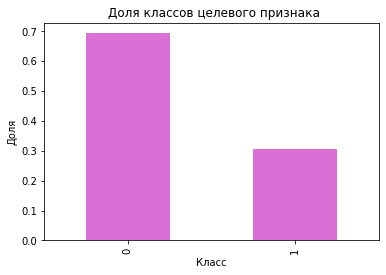

In [6]:
print(f"Количество строк в данных по классам: {np.bincount(df['is_ultra'])}")

class_frequency  =  df['is_ultra'].value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind = 'bar', color='orchid')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.title(' Доля классов целевого признака')
plt.show()

Классы не сбалансированы - 0 класс составляет 70%. Скорее всего качество модели относительно класса 1 (30%) будет низким.

Если 1 класс будет определен как целевой, то нужно будет поработать с балансом и выбрать верные метрики качества для оценки модели.

### Определение приоритетных метрик качества для моделей

Accuracy позволяет оценить насколько точно модель определяет класс, не зависимо от того целевой он или нет. Подходит для предварительной оценки модели.

Так как данная метрика (accuracy) не является объективной при дисбалансе классов, а у нас именно такая ситуация (примерно 70% на 30%), то воспользуемся дополнительными метриками для оценки качества модели.

Чтобы более точно определить, какая метрика приоритетна - точность (precision) или полнота (recall) определения целевого класса, необходимо оценить какой тариф приносит компании больше дохода:
- если нам будет более выгодно перевести клиента на дорогостоящий тариф, то ориентироваться будем на то, чтобы не упустить возможность предложить его клиенту, то есть приоритетной будет метрика recall (полнота). 
- если же мы определим, что клиенты, перелимичивая менее дорогостоящий пакет, приносят больше дохода, то предлагать перевестись будем на дорогостоящий тариф только тем, чьи предпочтения максимально соответствуют тарифу (кол-во сообщений, минут и т.д.). Тогда приоритетнее будет метрика precision (точность определения целевого класса - тарифа Ультра).

Для этого посчитаем доход от каждого клиента с учетом ежемесячной платы за тариф, включая перелемиты по тарифам.

In [7]:
# посмотрим параметры тарифов
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs['is_ultra'] = [0,1]
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,is_ultra
0,50,15360,500,550,200,3,3,smart,0
1,1000,30720,3000,1950,150,1,1,ultra,1


In [8]:
# добавим тарифы в общую таблицу данных
df_tariffs = df.merge(tariffs, how='left')

In [9]:
# посчитаем затраты клиента
def total_cost(df):
    user_minutes = 0
    user_messages = 0
    user_mb_used = 0
    tariff_cost = 0
    if (df['minutes'] - df['minutes_included']) > 0:
        user_minutes = (df['minutes'] - df['minutes_included'])*df['rub_per_minute']
    else:
        user_minutes = 0
    if (df['messages'] - df['messages_included']) > 0:
        user_messages = (df['messages'] - df['messages_included'])*df['rub_per_message']
    else:
        user_messages = 0
    if (df['mb_used'] - df['mb_per_month_included']) > 0:
        user_mb_used = np.ceil((df['mb_used'] - df['mb_per_month_included'])/ 1024).astype(int)*df['rub_per_gb']
    else:
        user_mb_used = 0  
    tariff_cost = df['rub_monthly_fee']
    return user_minutes + user_messages + user_mb_used + tariff_cost
    

In [10]:
# добавим общие затраты с учетом перелемитов в датафрейм
df_tariffs['total_cost'] = df_tariffs.apply(total_cost, axis=1)

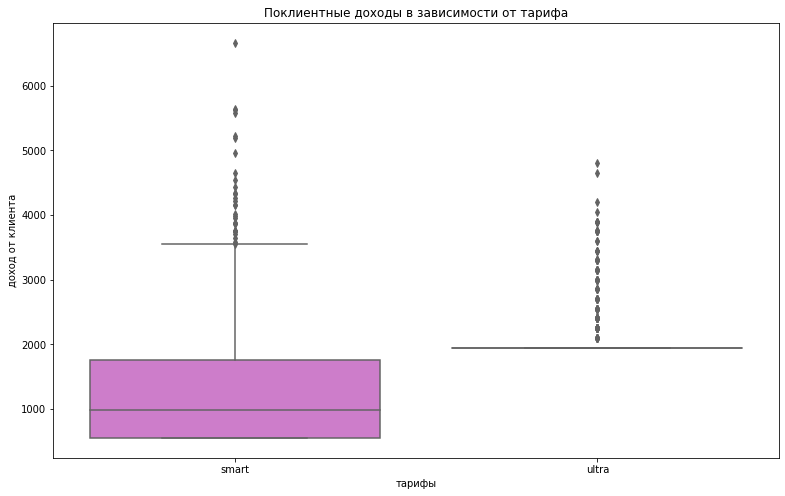

In [11]:
# посмотрим на распределение поклиентного дохода в зависимости от тарифа
data_temp, y = df_tariffs, 'total_cost'
plt.figure(figsize=(13, 8))
(sns.boxplot(data = data_temp, y = y, x='tariff_name', color='orchid')
    .set(title = 'Поклиентные доходы в зависимости от тарифа', xlabel = 'тарифы', ylabel = 'доход от клиента', ))
plt.show()

In [12]:
print('Доход от клиентов на тарифе Ультра')
display(df_tariffs.loc[df_tariffs['is_ultra'] == 1]['total_cost'].describe())
print('Общий доход от клиентов на тарифе ультра (медиана):', df_tariffs.loc[df_tariffs['is_ultra'] == 1]['total_cost'].median()*
     df_tariffs.loc[df_tariffs['is_ultra'] == 1]['total_cost'].count())

Доход от клиентов на тарифе Ультра


count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: total_cost, dtype: float64

Общий доход от клиентов на тарифе ультра (медиана): 1920750.0


In [13]:
print('Доход от клиентов на тарифе Смарт')
display(df_tariffs.loc[df_tariffs['is_ultra'] == 0]['total_cost'].describe())
print('Общий доход от клиентов на тарифе ультра (медиана):', df_tariffs.loc[df_tariffs['is_ultra'] == 0]['total_cost'].median()*
     df_tariffs.loc[df_tariffs['is_ultra'] == 0]['total_cost'].count())

Доход от клиентов на тарифе Смарт


count    2229.000000
mean     1271.904939
std       808.780306
min       550.000000
25%       550.000000
50%       989.000000
75%      1750.000000
max      6667.100000
Name: total_cost, dtype: float64

Общий доход от клиентов на тарифе ультра (медиана): 2204481.0


**Вывод по итогам определения приоритетных метрик качества для моделей**


1. Клиенты на тарифе Ультра практически не перелимичивают лимиты, включенные в тариф. Тем не менее, абонентская плата достаточно высокая, что обеспечивает больший средний (2070.15 руб.) и медианный доход (1950 руб.) (с учетом перелимитов) на клиента, чем на тарифе Смарт (средний - 1271.90 руб., медианный - 989 руб.).
2. Общий доход (по медианному значению) от клиентов на разных тарифах соизмерим - 1 920 750 руб. (Ультра) и  2 204 481 руб. (Смарт), несмотря на то, что клиентов на Смарт больше, чем на Ультра более чем в 2 раза. Соответственно, вес клиента на Ультра в общем доходе значительно больше, поэтому компании будет выгодно перевести клиента на дорогостоящий тариф. Ориентироваться будем на то, чтобы не упустить возможность предложить клиенту тариф Ультра (целевой класс), то есть **приоритетной будет метрика recall (полнота)** - зададим ей больший вес в fbeta_score, чем precision (точность определения целевого класса).

### Разделение данных на выборки

In [14]:
# подготовим признаки и целевой признак
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [15]:
# разделим данные на выборки
features_train, features_valid_t, target_train, target_valid_t = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_t, target_valid_t, test_size=0.5, random_state=12345)

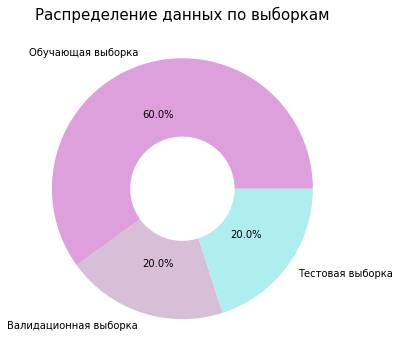

In [16]:
# построим круговую диаграмму по процентному соотношению полученных выборок
features_count = pd.Series([features_train['minutes'].count(), features_valid['minutes'].count(), 
                            features_test['minutes'].count()])
features_count.index = (['Обучающая выборка','Валидационная выборка', 'Тестовая выборка'])

fig, ax = plt.subplots( figsize = (6,6))
pallete = ['plum', 'thistle', 'paleturquoise']
ax.pie(features_count, labels=features_count.index, wedgeprops=dict(width=0.6), autopct='%1.1f%%', colors = pallete)
ax.set_title('Распределение данных по выборкам', fontsize = 15)

plt.show()

Рассмотрим выделенные выборки на сбалансированность - соотношение классов в целевом признаке.  

In [17]:
print(f"Количество строк в данных по классам: {np.bincount(df['is_ultra'])}, \
доля: {np.bincount(df['is_ultra'])/df['is_ultra'].count()}")
print(f"Количество строк в target_train по классам: {np.bincount(target_train)}, \
доля: {np.bincount(target_train)/target_train.count()}")
print(f"Количество строк в target_valid по классам: {np.bincount(target_valid)}, \
доля: {np.bincount(target_valid)/target_valid.count()}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}, \
доля: {np.bincount(target_test)/target_test.count()}")

Количество строк в данных по классам: [2229  985], доля: [0.69352831 0.30647169]
Количество строк в target_train по классам: [1335  593], доля: [0.69242739 0.30757261]
Количество строк в target_valid по классам: [454 189], доля: [0.70606532 0.29393468]
Количество строк в target_test по классам: [440 203], доля: [0.68429238 0.31570762]


Соотношение в исходных данных 69.4% и 30.6%. В выделенных таргетах распределение соответствует исходным данным.

### Оценка важности признаков

Далее построим гистограмму, которая показывает важность каждого признака. Это позволит определить наиболее важные характеристики, а также наименее важные - их можно будет исключить из машинного обучения, чтобы улучшить качество модели.

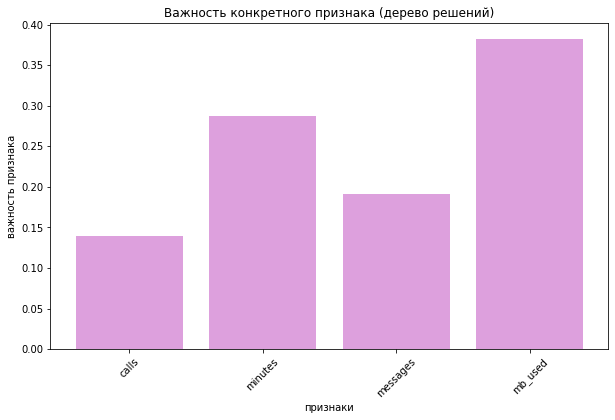

In [18]:
# оценим важность признаков (дерево решений) 
clt1 = DecisionTreeClassifier(random_state=12345)
clt1.fit(features_train, target_train)

plt.figure(figsize=(10,6))
plt.bar(features_train.columns, clt1.feature_importances_, color = 'plum')
plt.xticks(rotation=45)
plt.title('Важность конкретного признака (дерево решений)')
plt.xlabel("признаки")
plt.ylabel("важность признака")
plt.show()

Из диаграммы видно, что наименее важным признаком является количество звонков (calls). Это логично - не так важно, сколько звонков было совершено клиентом, важнее время разговора, так как именно этот признак входит в лимит тарифа.

С целью получения более качественной модели "дерево решений" можно обучить две модели - с признаком calls и без него (убрав признак можно уменьшить искажения при разделении узлов).


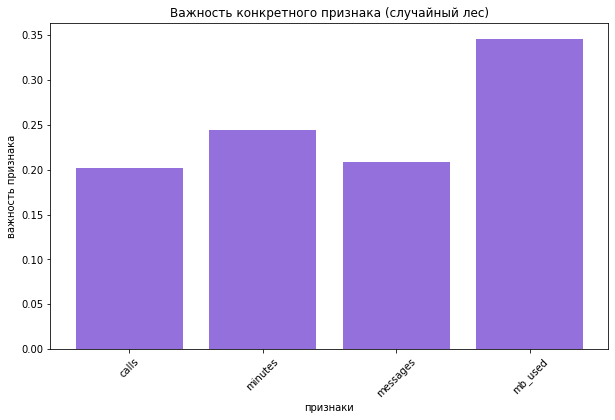

In [19]:
# оценим важность признаков (случайный лес) 
clf1 = RandomForestClassifier(random_state=12345)
clf1.fit(features_train, target_train)

plt.figure(figsize=(10,6))
plt.bar(features_train.columns, clf1.feature_importances_, color = 'mediumpurple')
plt.xticks(rotation=45)
plt.title('Важность конкретного признака (случайный лес)')
plt.xlabel("признаки")
plt.ylabel("важность признака")
plt.show()

Для модели 'случайный лес' не выявлено признака, который был бы наименее важным.

Стоит отметить, что в обеих моделях ("дерево решений" и "случайный лес") наиболее важным признаком является израсходованный интернет-трафик.

Далее проведем сравнение моделей для оценки качества предсказаний (обучение с учителем). 
Будем применять к данным модели для бинарной классификации - у целевого признака только две категории.

## Исследование качества моделей

### Дерево решений

С целью подбора гиперпараметров решающего дерева оценим влияние глубины дерева на качество модели.

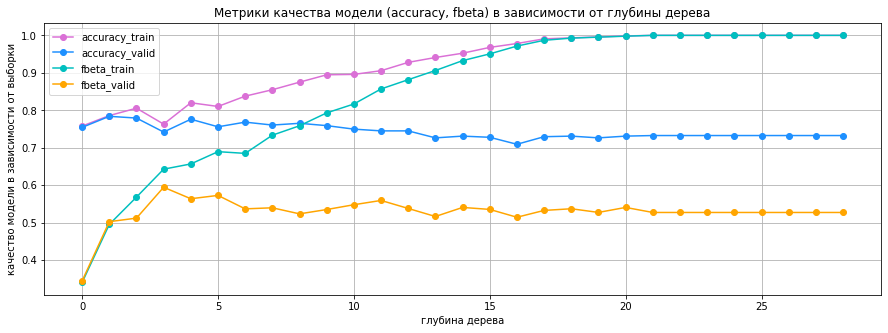

In [20]:
# построим график по метрикам качества модели на тренировочной и валидационной выборках
accuracy_train = []
accuracy_valid = []
fbeta_train = []
fbeta_valid = []

for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced') # применим балансировку
    model.fit(features_train, target_train)
    predictions_train = model.predict(features_train) # получим предсказание
    result_train_ac = accuracy_score(target_train, predictions_train) # посчитаем качество модели
    result_train_f = fbeta_score(target_train, predictions_train, beta=1.5) # beta=1.5 добавляет вес recall
    predictions_valid = model.predict(features_valid)
    result_valid_ac = accuracy_score(target_valid, predictions_valid)
    result_valid_f = fbeta_score(target_valid, predictions_valid, beta=1.5)
    accuracy_train.append(result_train_ac)
    accuracy_valid.append(result_valid_ac)
    fbeta_train.append(result_train_f)
    fbeta_valid.append(result_valid_f)

accuracy_train = pd.Series(accuracy_train)
accuracy_valid = pd.Series(accuracy_valid)
fbeta_train = pd.Series(fbeta_train)
fbeta_valid = pd.Series(fbeta_valid)

accuracy_train.plot(style='o-', grid=True, color='orchid', figsize=(15,5), \
              title='Метрики качества модели (accuracy, fbeta) в зависимости от глубины дерева')
accuracy_valid.plot(style='o-', grid=True, color = 'dodgerblue')
fbeta_train.plot(style='o-', grid=True, color='c')
fbeta_valid.plot(style='o-', grid=True, color = 'orange')

plt.legend(['accuracy_train', 'accuracy_valid', 'fbeta_train', 'fbeta_valid'])
plt.xlabel("глубина дерева")
plt.ylabel("качество модели в зависимости от выборки")
plt.show()

Из графика видно, что максимальное значение метрики fbeta (именно она нам важна, чтобы оценить приоритетно полноту, но и не забыть про точность модели) на валидационной выборке достигается при глубине дерева равной 3, далее значения остаются в пределах 0.5 - 0.57. 

Accuracy более 0.75 на валидационной выборке при глубине дерева от 1 до 10.

Проверим качество моделей с глубиной дерева от 1 до 10.

А для определения прочих гиперпараметров модели (min_samples_leaf', 'min_samples_split') воспользуемся автоматическим подбором параметров (GridSearchCV).

In [21]:
# глубину дерева зададим исходя из полученных данных (от 1 до 10)
clt = DecisionTreeClassifier(random_state=12345)
parametrs = { 'max_depth': range (1,10),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10) }

In [22]:
grid = GridSearchCV(clt, parametrs, cv=5)
grid.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10)})

In [23]:
# гиперпараметры для модели
grid.best_params_

{'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 2}

In [24]:
# применим полученные гиперпараметры на обучающей и валидационной выборке и оценим качество модели
clt = DecisionTreeClassifier(random_state=12345, max_depth=6, min_samples_leaf=7, min_samples_split=2, class_weight='balanced')
clt.fit(features_train, target_train)
predictions_train_clt = clt.predict(features_train) # получим предсказание
result_train_clt = accuracy_score(target_train, predictions_train_clt) # посчитаем качество модели
result_train_clt_f = fbeta_score(target_train, predictions_train_clt, beta=1.5)
print('accuracy модели дерева решений на обучающей выборке:',result_train_clt)
print('fbeta модели дерева решений на обучающей выборке:',result_train_clt_f)

print('------------------------------------------------------')
predictions_valid_clt = clt.predict(features_valid)
result_valid_clt = accuracy_score(target_valid, predictions_valid_clt) # общая точность (доля правильных ответов по классам)
result_valid_clt_f = fbeta_score(target_valid, predictions_valid_clt, beta=1.5)
print('accuracy модели дерева решений на валидационной выборке:',result_valid_clt)
print('fbeta модели дерева решений на валидационной выборке:',result_valid_clt_f)

accuracy модели дерева решений на обучающей выборке: 0.8013485477178424
fbeta модели дерева решений на обучающей выборке: 0.6775573706728899
------------------------------------------------------
accuracy модели дерева решений на валидационной выборке: 0.7573872472783826
fbeta модели дерева решений на валидационной выборке: 0.5839118007349938


In [25]:
# определим гиперпараметры без признака calls
features_train_not_calls = features_train.drop(['calls'], axis=1)
features_valid_not_calls = features_valid.drop(['calls'], axis=1)
grid.fit(features_train_not_calls, target_train)
grid.best_params_

{'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 2}

In [26]:
# обучим модель без признака calls
clt_2 = DecisionTreeClassifier(random_state=12345, max_depth=7, min_samples_leaf=7, min_samples_split=2, class_weight='balanced')
clt_2.fit(features_train_not_calls, target_train)
predictions_train_clt_2 = clt_2.predict(features_train_not_calls) # получим предсказание
result_train_clt_2 = accuracy_score(target_train, predictions_train_clt_2) # посчитаем качество модели
result_train_clt_f_2 = fbeta_score(target_train, predictions_train_clt_2, beta=1.5)
print('accuracy модели дерева решений (без признака calls) на обучающей выборке:',result_train_clt_2)
print('fbeta модели дерева решений (без признака calls) на обучающей выборке:',result_train_clt_f_2)

print('------------------------------------------------------')
predictions_valid_clt_2 = clt_2.predict(features_valid_not_calls)
result_valid_clt_2 = accuracy_score(target_valid, predictions_valid_clt_2) # общая точность (доля правильных ответов по классам)
result_valid_clt_f_2 = fbeta_score(target_valid, predictions_valid_clt_2, beta=1.5)
print('accuracy модели дерева решений (без признака calls) на валидационной выборке:',result_valid_clt_2)
print('fbeta модели дерева решений (без признака calls) на валидационной выборке:',result_valid_clt_f_2)

accuracy модели дерева решений (без признака calls) на обучающей выборке: 0.8366182572614108
fbeta модели дерева решений (без признака calls) на обучающей выборке: 0.6662477307638599
------------------------------------------------------
accuracy модели дерева решений (без признака calls) на валидационной выборке: 0.7807153965785381
fbeta модели дерева решений (без признака calls) на валидационной выборке: 0.5442926399294844


Модель без признака calls показывает более высокие показатели метрики accuracy, но значения fbeta снизились. Это значит, что полнота определения целевых классов понизилась, а accuracy выросла за счет увеличения точности определения целевых классов.

Так как нам приоритетнее полнота, то оставим модель без изменений (с признаком calls).

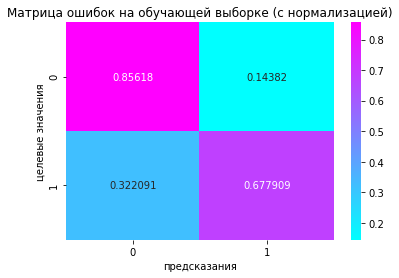

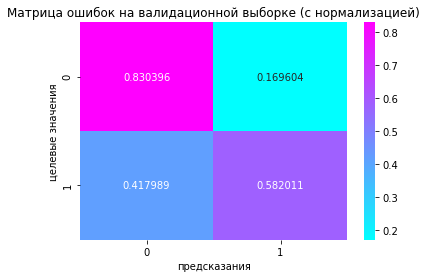

In [27]:
# построим матрицу ошибок
cm = confusion_matrix(target_train, predictions_train_clt, normalize='true')
sns.heatmap(cm, annot=True,  fmt='g', cmap='cool')

plt.title('Матрица ошибок на обучающей выборке (с нормализацией)')
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

cm = confusion_matrix(target_valid, predictions_valid_clt,  normalize='true')
sns.heatmap(cm, annot=True,  fmt='g', cmap='cool')

plt.title('Матрица ошибок на валидационной выборке (с нормализацией)')
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

**Оценив матрицу ошибок и метрики качества можно сделать следующие выводы:**
1. accuracy лучшей модели (дерево решений) выше 0.75 (0.8 на обучающей и 0.76 на валидационной выборках), но, так как наблюдается дисбаланс классов (70% и 30%), то эта метрика не достаточно информативна для оценки качества модели;
2. исходя из дополнительной метрики fbeta, а также матрицы ошибок, можно отметить:
    - модель предсказывает 0 класс (тариф Смарт) отлично на обучающей выборке (86%), а на валидационной - 82%. К классу 1 ошибочно было отнесено 14-18% (False Positive);
    - с предсказанием целевого класса 1 (тариф Ультра) модель справляется не так хорошо - около 58% (True Positive) на валидационной выборке;
    - средневзвешенное гармоническое значение точности и полноты, где с большим весом оценивалась полнота, низкое (fbeta на валидационнной выборке 0.58). 

### Случайный лес

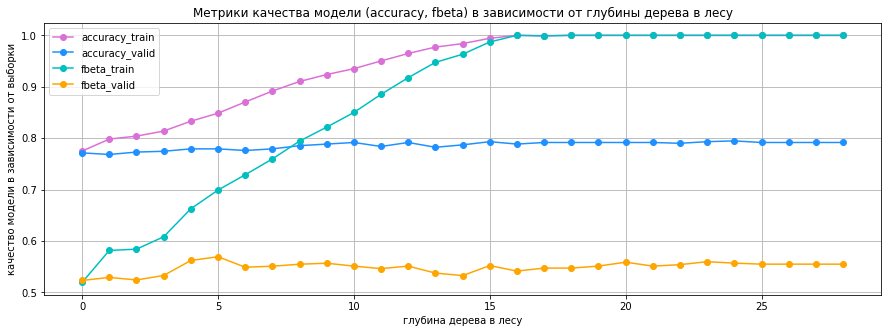

In [28]:
# построим график качества модели на тренировочной и валидационной выборках
accuracy_train = []
accuracy_valid = []
fbeta_train = []
fbeta_valid = []

for depth in range(1, 30):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, class_weight='balanced') 
        model.fit(features_train, target_train)
        predictions_train = model.predict(features_train) # получим предсказание
        result_train_ac = accuracy_score(target_train, predictions_train) # посчитаем качество модели
        result_train_f = fbeta_score(target_train, predictions_train, beta=1.5)
        predictions_valid = model.predict(features_valid)
        result_valid_ac = accuracy_score(target_valid, predictions_valid)
        result_valid_f = fbeta_score(target_valid, predictions_valid, beta=1.5)
        accuracy_train.append(result_train_ac)
        accuracy_valid.append(result_valid_ac)
        fbeta_train.append(result_train_f)
        fbeta_valid.append(result_valid_f)

accuracy_train = pd.Series(accuracy_train)
accuracy_valid = pd.Series(accuracy_valid)
fbeta_train = pd.Series(fbeta_train)
fbeta_valid = pd.Series(fbeta_valid)

accuracy_train.plot(style='o-', grid=True, color='orchid', figsize=(15,5), \
              title='Метрики качества модели (accuracy, fbeta) в зависимости от глубины дерева в лесу')
accuracy_valid.plot(style='o-', grid=True, color = 'dodgerblue')
fbeta_train.plot(style='o-', grid=True, color='c')
fbeta_valid.plot(style='o-', grid=True, color = 'orange')

plt.legend(['accuracy_train', 'accuracy_valid', 'fbeta_train', 'fbeta_valid'])
plt.xlabel("глубина дерева в лесу")
plt.ylabel("качество модели в зависимости от выборки")
plt.show()

Из графика видно, что при увеличении глубины деревьев accuracy по валидационной выборке практически не изменяется.

fbeta на валидационной выборке возрастает с глубиной дерева 4-5, далее снижается и незначительно варьируется.

Выберем диапазон глубины 4-5.

Далее проанализируем гиперпараметр количество деревьев в случайном лесу.

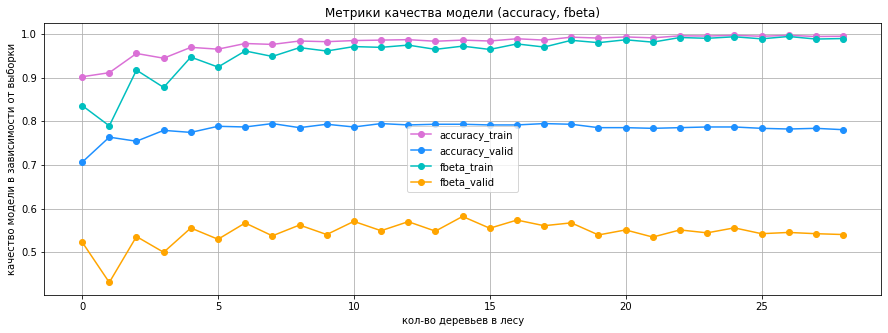

In [29]:
accuracy_train = []
accuracy_valid = []
fbeta_train = []
fbeta_valid = []

for estimator in range(1,30):
        model = RandomForestClassifier(random_state=12345, n_estimators=estimator, class_weight='balanced') 
        model.fit(features_train, target_train)
        predictions_train = model.predict(features_train) # получим предсказание
        result_train_ac = accuracy_score(target_train, predictions_train) # посчитаем качество модели
        result_train_f = fbeta_score(target_train, predictions_train, beta=1.5)
        predictions_valid = model.predict(features_valid)
        result_valid_ac = accuracy_score(target_valid, predictions_valid)
        result_valid_f = fbeta_score(target_valid, predictions_valid, beta=1.5)
        accuracy_train.append(result_train_ac)
        accuracy_valid.append(result_valid_ac)
        fbeta_train.append(result_train_f)
        fbeta_valid.append(result_valid_f)

accuracy_train = pd.Series(accuracy_train)
accuracy_valid = pd.Series(accuracy_valid)
fbeta_train = pd.Series(fbeta_train)
fbeta_valid = pd.Series(fbeta_valid)

accuracy_train.plot(style='o-', grid=True, color='orchid', figsize=(15,5), \
              title='Метрики качества модели (accuracy, fbeta)')
accuracy_valid.plot(style='o-', grid=True, color = 'dodgerblue')
fbeta_train.plot(style='o-', grid=True, color='c')
fbeta_valid.plot(style='o-', grid=True, color = 'orange')

plt.legend(['accuracy_train', 'accuracy_valid', 'fbeta_train', 'fbeta_valid'])
plt.xlabel("кол-во деревьев в лесу")
plt.ylabel("качество модели в зависимости от выборки")
plt.show()

Из графика видно, что accuracy на валидационной выборке достигает максимума при 5 деревьях, далее незначительно варьируется. 

fbeta по валидационной выборке достигает максимума при 14 деревьях.
при увеличении количества деревьев в лесу до 14 наблюдается незначительный рост метрики fbeta по валидационной выборке, далее значения метрики снижаются.

Проверим качество модели с количеством от 5 до 14 деревьев.

А для определения прочих гиперпараметров модели (min_samples_leaf', 'min_samples_split') воспользуемся автоматическим подбором параметров (GridSearchCV).

In [30]:
clf = RandomForestClassifier(random_state=12345)

In [31]:
# при определении диапазона гиперпараметров воспользуемся информацией, полученной из графиков выше
parametrs = { 'n_estimators': range (5, 15),
              'max_depth': range (4,6),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10) }

In [32]:
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': range(4, 6),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10),
                         'n_estimators': range(5, 15)})

In [33]:
grid.best_params_

{'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 7}

In [34]:
# применим полученные гиперпараметры на обучающей и валидационной выборке и оценим качество модели
clf = RandomForestClassifier(random_state=12345, max_depth=5, min_samples_leaf=5, min_samples_split=2, 
                             n_estimators=7, class_weight='balanced')
clf.fit(features_train, target_train)
predictions_train_clf = clf.predict(features_train) # получим предсказание
result_train_clf = accuracy_score(target_train, predictions_train_clf) # посчитаем качество модели
result_train_clf_f = fbeta_score(target_train, predictions_train_clf, beta=1.5)
print('accuracy модели случайный лес на обучающей выборке:',result_train_clf)
print('fbeta модели случайный лес на обучающей выборке:',result_train_clf_f)

print('------------------------------------------------------')
predictions_valid_clf = clf.predict(features_valid)
result_valid_clf = accuracy_score(target_valid, predictions_valid_clf) # общая точность (доля правильных ответов по классам)
result_valid_clf_f = fbeta_score(target_valid, predictions_valid_clf, beta=1.5)
print('accuracy модели случайный лес на валидационной выборке:',result_valid_clf)
print('fbeta модели случайный лес на валидационной выборке:',result_valid_clf_f)

accuracy модели случайный лес на обучающей выборке: 0.8241701244813278
fbeta модели случайный лес на обучающей выборке: 0.6466490176954159
------------------------------------------------------
accuracy модели случайный лес на валидационной выборке: 0.7729393468118196
fbeta модели случайный лес на валидационной выборке: 0.5395369156837047


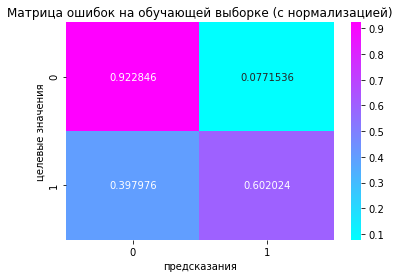

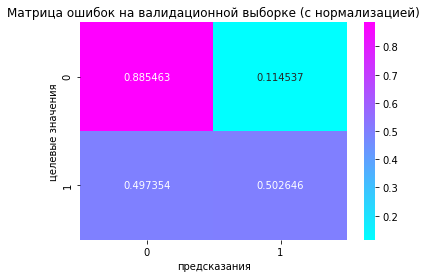

In [35]:
# построим матрицу ошибок
cm_clf = confusion_matrix(target_train, predictions_train_clf,  normalize='true')
sns.heatmap(cm_clf, annot=True,  fmt='g', cmap='cool')

plt.title('Матрица ошибок на обучающей выборке (с нормализацией)')
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

cm_clf = confusion_matrix(target_valid, predictions_valid_clf,  normalize='true')
sns.heatmap(cm_clf, annot=True,  fmt='g', cmap='cool')

plt.title('Матрица ошибок на валидационной выборке (с нормализацией)')
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

**Оценив матрицу ошибок и метрики качества можно сделать следующие выводы:**
1. accuracy лучшей модели (случайный лес) выше 0.75 (0.82 на обучающей и 0.77 на валидационной выборках);
2. исходя из дополнительной метрики fbeta, а также матрицы ошибок, можно отметить:
    - модель достаточно хорошо предсказывает 0 класс (тариф Смарт) как на обучающей выборке (0.92), так и на валидационной (0.89). К классу 1 ошибочно было отнесено 8-11% (False Positive);
    - с предсказанием целевого класса 1 (тариф Ультра) модель справляется не так хорошо - на валидационной выборке только в 50% случаев предсказывает целевой класс (True Positive);
    - средневзвешенное гармоническое значение точности и полноты, где с большим весом оценивалась полнота, низкое (fbeta на валидационной выборке 0.54). 

### Логистическая регрессия

In [36]:
logreg = LogisticRegression(random_state = 12345, solver='liblinear')

In [37]:
parametrs = {'C': np.logspace(-4, 4, 50), 'penalty': ['l1', 'l2']}

In [38]:
grid = GridSearchCV(logreg, parametrs, cv=5)
grid.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=12345,
                                          solver='liblinear'),
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']})

In [39]:
grid.best_params_

{'C': 3.727593720314938, 'penalty': 'l1'}

In [40]:

logreg = LogisticRegression(random_state=12345, solver='liblinear', C= 3.727593720314938, penalty='l2') # применим балансировку
logreg.fit(features_train, target_train)
predictions_train_logreg = logreg.predict(features_train) # получим предсказание
result_train_logreg = accuracy_score(target_train, predictions_train_logreg) # посчитаем качество модели
result_train_logreg_f = fbeta_score(target_train, predictions_train_logreg, beta=1.5)
print('accuracy модели "логистическая регрессия" на обучающей выборке:', result_train_logreg)
print('fbeta модели "логистическая регрессия" на обучающей выборке:',result_train_logreg_f)

print('------------------------------------------------------')
predictions_valid_logreg = logreg.predict(features_valid)
result_valid_logreg = accuracy_score(target_valid, predictions_valid_logreg)
result_valid_logreg_f = fbeta_score(target_valid, predictions_valid_logreg, beta=1.5)
print('accuracy модели "логистическая регрессия" на валидационной выборке:',result_valid_logreg)
print('fbeta модели "логистическая регрессия" на валидационной выборке:',result_valid_logreg_f)

accuracy модели "логистическая регрессия" на обучающей выборке: 0.7479253112033195
fbeta модели "логистическая регрессия" на обучающей выборке: 0.26949872557349197
------------------------------------------------------
accuracy модели "логистическая регрессия" на валидационной выборке: 0.7542768273716952
fbeta модели "логистическая регрессия" на валидационной выборке: 0.25093833780160857


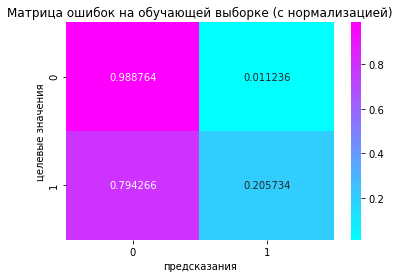

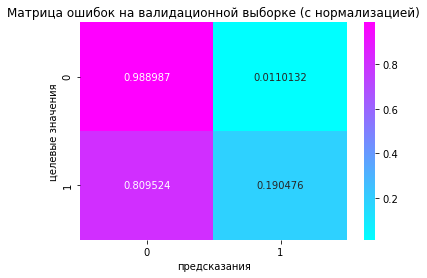

In [41]:
# построим матрицу ошибок
cm_logreg = confusion_matrix(target_train, predictions_train_logreg,  normalize='true')
sns.heatmap(cm_logreg, annot=True,  fmt='g', cmap='cool')

plt.title('Матрица ошибок на обучающей выборке (с нормализацией)')
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

cm_logreg = confusion_matrix(target_valid, predictions_valid_logreg,  normalize='true')
sns.heatmap(cm_logreg, annot=True,  fmt='g', cmap='cool')

plt.title('Матрица ошибок на валидационной выборке (с нормализацией)')
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

**Оценив матрицу ошибок и метрики качества можно сделать следующие выводы:**
1. accuracy логистической регрессии составляет 0.75 на обучающей и на валидационной выборках;
2. модель предсказывает 0 класс с точностью 0.99 как на обучающей, так и на тестовой выборках;
3. тем не менее, модель имеет очень низкое качество предсказаний целевого класса -  только 20% класса 1 предсказано верно (True Positive). fbeta на валидационной выборке - 0.25 (самое низкое значение из всех рассматриваемых моделей). 

## Проверьте модель на тестовой выборке

Все полученные модели соответствуют критерию "accuracy выше 0.75" (на валидационной выборке).

Сравним метрики качества моделей на тестовой выборке.

In [42]:
# модель дерево решений
predictions_test_clt = clt.predict(features_test)
result_test_clt = accuracy_score(target_test, predictions_test_clt) 
result_test_clt_f = fbeta_score(target_test, predictions_test_clt, beta=1.5)
print('accuracy модели "дерево решений" на тестовой выборке:',result_test_clt)
print('fbeta модели "дерево решений" на тестовой выборке:',result_test_clt_f)

accuracy модели "дерево решений" на тестовой выборке: 0.7713841368584758
fbeta модели "дерево решений" на тестовой выборке: 0.6242796772954282


In [43]:
# модель случайный лес
predictions_test_clf = clf.predict(features_test)
result_test_clf = accuracy_score(target_test, predictions_test_clf) 
result_test_clf_f = fbeta_score(target_test, predictions_test_clf, beta=1.5)
print('accuracy модели случайный лес на тестовой выборке:',result_test_clf)
print('fbeta модели случайный лес на тестовой выборке:',result_test_clf_f)

accuracy модели случайный лес на тестовой выборке: 0.8009331259720062
fbeta модели случайный лес на тестовой выборке: 0.6240419524001614


In [44]:
# модель логистической регрессии
predictions_test_logreg = logreg.predict(features_test)
result_test_logreg = accuracy_score(target_test, predictions_test_logreg)
result_test_logreg_f = fbeta_score(target_test, predictions_test_logreg, beta=1.5)
print('accuracy модели логистической регрессии на тестовой выборке:',result_test_logreg)
print('fbeta модели логистической регрессии на тестовой выборке:',result_test_logreg_f)

accuracy модели логистической регрессии на тестовой выборке: 0.7262830482115086
fbeta модели логистической регрессии на тестовой выборке: 0.23870967741935484


**Две модели (из анализируемых) показывают accuracy выше 0.75 на тестовой выборке**:
1. Дерево решений (0.77)
2. Случайный лес (0.80)

Несмотря на то, что модель "случайный лес" имеет более высокую общую точность, значения метрики fbeta у двух моделей равны (0.62). Именно эта метрика является приоритетной в данном случае, так как в начале проекта была определена цель компании - перевести как можно больше клиентов на тариф Ультра (класс 1) для увеличения дохода.

Посмотрим матрицы ошибок по этим моделям.

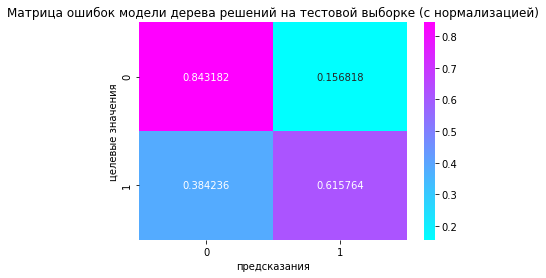

In [45]:
# дерево решений
cm = confusion_matrix(target_test, predictions_test_clt,  normalize='true')
sns.heatmap(cm, annot=True,  fmt='g', cmap='cool')

plt.title('Матрица ошибок модели дерева решений на тестовой выборке (с нормализацией)')
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

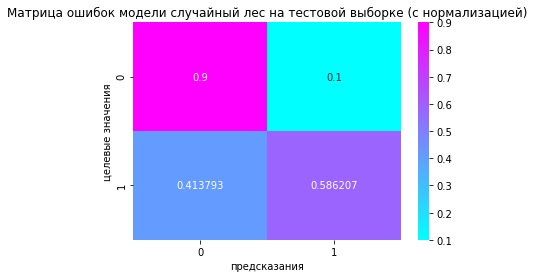

In [46]:
# случайный лес
cm_clf = confusion_matrix(target_test, predictions_test_clf,  normalize='true')
sns.heatmap(cm_clf, annot=True,  fmt='g', cmap='cool')

plt.title('Матрица ошибок модели случайный лес на тестовой выборке (с нормализацией)')
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

Модель дерева решений определила чуть больший процент целевого класса 1 (тариф Ультра) - 62% (дерево решений) и 59% - (случайный лес), соответственно и порекомендует его большему количеству клиентов. 0 класс лучше предсказывает модель случайного леса - 90% (дерево решений - 84%).

Еще одним плюсом модели **дерева решений** является ее быстрота, поэтому приоритет отдадим именно этой модели:

**clt = DecisionTreeClassifier(random_state=12345, max_depth=6, min_samples_leaf=7, min_samples_split=2, class_weight='balanced')**

## Проверка модели на адекватность

Для проверки нашей модели на адекватность сравним ее с некоторой baseline моделью, которая будет выдавать самое часто встречающееся значение в целевом признаке вне зависимости от того какие данные ей подаются на вход. Это позволит проконтролировать, что полученная модель дерева решений действительно дает нам прирост качества.

In [47]:
dummy_model = DummyClassifier(strategy="most_frequent") # модель возвращает наиболее часто встречающуюся метку класса 
dummy_model.fit(features_train, target_train) 

# рассчитаем метрики качества
predictions_train_dummy_model =dummy_model.predict(features_train)
result_train_dummy_model = accuracy_score(target_train, predictions_train_dummy_model) # посчитаем качество модели
result_train_dummy_model_f = fbeta_score(target_train, predictions_train_dummy_model, beta=1.5)
print('accuracy модели baseline на обучающей выборке:', result_train_dummy_model)
print('fbeta модели baseline на обучающей выборке:',result_train_dummy_model_f)

print('------------------------------------------------------')
predictions_test_dummy_model = dummy_model.predict(features_test)
result_test_dummy_model = accuracy_score(target_test, predictions_test_dummy_model)
result_test_dummy_model_f = fbeta_score(target_test, predictions_test_dummy_model, beta=1.5)
print('accuracy модели baseline на тестовой выборке:',result_test_dummy_model)
print('fbeta модели baseline на тестовой выборке:',result_test_dummy_model_f)

accuracy модели baseline на обучающей выборке: 0.6924273858921162
fbeta модели baseline на обучающей выборке: 0.0
------------------------------------------------------
accuracy модели baseline на тестовой выборке: 0.6842923794712286
fbeta модели baseline на тестовой выборке: 0.0


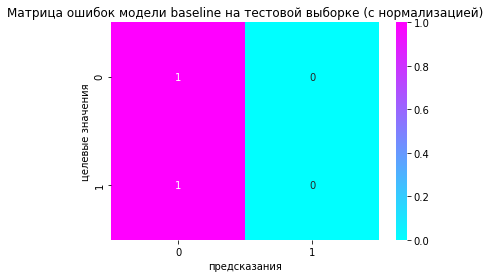

In [48]:
# построим матрицу ошибок
cm_dummy_model = confusion_matrix(target_test, predictions_test_dummy_model, normalize='true')
sns.heatmap(cm_dummy_model, annot=True,  fmt='g', cmap='cool')

plt.title('Матрица ошибок модели baseline на тестовой выборке (с нормализацией)')
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

**Вывод:**
accuracy модели baseline на тестовой выборке составляет 0.68 (ниже 0.75), кроме того модель baseline не выявила ни одного объекта с классом 1. 

Таким образом, можно считать, что полученная модель дерева решений прошла проверку на адекватность:
- accuracy модели "дерево решений" на тестовой выборке: 0.77
- fbeta модели "дерево решений" на тестовой выборке: 0.62